# 01 — Data & Scraping
Goal: load phishing/legit URL lists, basic EDA, scrape small HTML sample, save urls table.

Originally written in vscode but transferred over to notebook, long cells etc are a factor of this

Large functions for code reusability incase of dataset switch. Will have to change 'type' to however other dataset labels urls

Logic is not part of this however some of the 'plotting' code to generate tables etc has been written/assisted by chatgpt for clean plots and time reasons

In [1]:
import pandas as pd
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
from collections import Counter
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

In [10]:
# plot styles
plt.style.use('seaborn-v0_8')
sns.set_palette("husl")

In [11]:
DATA_RAW = Path("../data/raw")
DATA_PROC = Path("../data/processed")
DATA_RAW.mkdir(parents=True, exist_ok=True)
DATA_PROC.mkdir(parents=True, exist_ok=True)

In [12]:
df = pd.read_csv(DATA_RAW / "malicious_phish.csv")
df.shape

(651191, 2)

In [13]:
df.head()

,url,type
0,br-icloud.com.br,phishing
1,mp3raid.com/music/krizz_kaliko.html,benign
2,bopsecrets.org/rexroth/cr/1.htm,benign
3,http://www.garage-pirenne.be/index.php?option=...,defacement
4,http://adventure-nicaragua.net/index.php?optio...,defacement


In [14]:
df['type'].value_counts()

type
benign        428103
defacement     96457
phishing       94111
malware        32520
Name: count, dtype: int64

In [15]:
label_map = {
    'benign': 0,
    'phishing': 1,
    'malware': 2,
    'defacement':3
}

In [16]:
df['label'] = df['type'].map(label_map)

In [17]:
df.duplicated(subset='url').sum()
df = df.drop_duplicates(subset=['url']).reset_index(drop=True)
df.shape

(641119, 3)

# Data Quality Analysis

In [22]:
def analyse_data_quality(df):
    # no. of mssing values
    print("\n1. Missing Values:")
    print(df.isnull().sum())
    
    # format analysis
    print("\n2. URL Format Analysis:")
    http_count = df['url'].str.contains(r'^https?://', case=False).sum()
    domain_only = df['url'].str.contains(r'^[^/]+\.[^/]+$', case=False).sum()
    relative_paths = df['url'].str.contains(r'^[^/]+/', case=False).sum()
    
    print(f"URLs with protocol (http/https): {http_count:,} ({http_count/len(df):.1%})")
    print(f"Domain-only URLs: {domain_only:,} ({domain_only/len(df):.1%})")
    print(f"URLs with paths: {relative_paths:,} ({relative_paths/len(df):.1%})")
    
    # more hardcoded approach checking if sites we are know are real come under legit
    print("\n3. Legitimate Domains Analysis:")
    legitimate_domains = ['google', 'wikipedia', 'github', 'stackoverflow', 'microsoft', 
                         'amazon', 'facebook', 'twitter', 'youtube', 'apple']
    
    for domain in legitimate_domains:
        mask = df['url'].str.contains(domain, case=False, na=False)
        if mask.any():
            print(f"\n{domain.title()} URLs by type:")
            type_counts = df[mask]['type'].value_counts()
            for url_type, count in type_counts.items():
                print(f"  {url_type}: {count}")
    
    # URL length distribution
    print(f"\n4. URL Length Statistics:")
    df['url_length'] = df['url'].str.len()
    print(f"Min length: {df['url_length'].min()}")
    print(f"Max length: {df['url_length'].max()}")
    print(f"Mean length: {df['url_length'].mean():.2f}")
    print(f"URLs > 200 chars: {(df['url_length'] > 200).sum():,}")
    
    return df

In [23]:
df = analyze_data_quality(df)


1. Missing Values:
url           0
type          0
label         0
url_length    0
dtype: int64

2. URL Format Analysis:
URLs with protocol (http/https): 177,954 (27.8%)
Domain-only URLs: 22,438 (3.5%)
URLs with paths: 618,630 (96.5%)

3. Legitimate Domains Analysis:

Google URLs by type:
  benign: 3338
  phishing: 1301
  malware: 254
  defacement: 43

Wikipedia URLs by type:
  benign: 13118
  phishing: 563
  defacement: 4

Github URLs by type:
  phishing: 32
  benign: 4
  malware: 2

Stackoverflow URLs by type:
  benign: 262
  phishing: 4

Microsoft URLs by type:
  phishing: 508
  benign: 259
  malware: 108
  defacement: 17

Amazon URLs by type:
  benign: 5304
  phishing: 230
  defacement: 82
  malware: 17

Facebook URLs by type:
  benign: 8666
  phishing: 239
  defacement: 34
  malware: 31

Twitter URLs by type:
  benign: 2024
  malware: 24
  phishing: 12
  defacement: 7

Youtube URLs by type:
  benign: 8806
  defacement: 108
  phishing: 20
  malware: 6

Apple URLs by type:
  phishi

# more 'advanced' url analysis

In [25]:
def enhanced_url_analysis(df):
    
    # same as before
    reverse_label_map = {0: 'benign', 1: 'phishing', 2: 'malware', 3: 'defacement'}
    df['type'] = df['label'].map(reverse_label_map)
    
    # construct features, length, has https etc
    df['url_length'] = df['url'].str.len()
    df['domain'] = df['url'].str.extract(r'(?:https?://)?(?:www\.)?([^/]+)')[0]
    df['has_https'] = df['url'].str.contains('https://', case=False, na=False)
    df['special_char_count'] = df['url'].str.count(r'[^a-zA-Z0-9]')
    df['digit_count'] = df['url'].str.count(r'\d')
    
    fig, axes = plt.subplots(2, 3, figsize=(18, 12))
    fig.suptitle('Comprehensive URL Analysis Dashboard', fontsize=16, fontweight='bold')
    
    # url length distribution
    ax1 = axes[0, 0]
    colors = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728']
    for i, (type_name, color) in enumerate(zip(df['type'].unique(), colors)):
        if pd.notna(type_name):
            subset = df[df['type'] == type_name]['url_length']
            ax1.hist(subset, alpha=0.7, label=f'{type_name} (n={len(subset):,})', 
                    bins=50, color=color, density=True)
    
    ax1.set_xlabel('URL Length (characters)')
    ax1.set_ylabel('Density')
    ax1.set_title('URL Length Distribution by Type')
    ax1.legend()
    ax1.set_yscale('log')
    ax1.grid(True, alpha=0.3)
    
    # domain 'diversity' analysis
    ax2 = axes[0, 1]
    domain_counts = df.groupby('type')['domain'].nunique().sort_values(ascending=False)
    bars = ax2.bar(domain_counts.index, domain_counts.values, color=colors)
    ax2.set_title('Unique Domains by Type')
    ax2.set_ylabel('Number of Unique Domains')
    ax2.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax2.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontweight='bold')
    
    # https vs http
    ax3 = axes[0, 2]
    protocol_analysis = df.groupby(['type', 'has_https']).size().unstack(fill_value=0)
    protocol_analysis.plot(kind='bar', stacked=True, ax=ax3, 
                          color=['#ff6b6b', '#4ecdc4'])
    ax3.set_title('HTTPS vs HTTP Usage by Type')
    ax3.set_ylabel('Number of URLs')
    ax3.tick_params(axis='x', rotation=45)
    ax3.legend(['HTTP', 'HTTPS'])
    
    # more 'suspicious' patterns analysis
    ax4 = axes[1, 0]
    suspicious_patterns = {
        'IP Address': r'\d+\.\d+\.\d+\.\d+',
        'Multiple Subdomains': r'[^/]*\..*\..*\.',
        'URL Shorteners': r'(?:bit\.ly|tinyurl|t\.co|goo\.gl|short)',
        'Suspicious TLDs': r'\.(?:tk|ml|ga|cf)(?:/|$)',
    }
    
    pattern_counts = {}
    for pattern_name, pattern in suspicious_patterns.items():
        count = df['url'].str.contains(pattern, case=False, na=False).sum()
        pattern_counts[pattern_name] = count
    
    bars = ax4.bar(pattern_counts.keys(), pattern_counts.values(), 
                   color=['#e74c3c', '#f39c12', '#9b59b6', '#34495e'])
    ax4.set_title('Suspicious URL Patterns')
    ax4.set_ylabel('Number of URLs')
    ax4.tick_params(axis='x', rotation=45)
    
    for bar in bars:
        height = bar.get_height()
        ax4.text(bar.get_x() + bar.get_width()/2., height + height*0.01,
                f'{height:,}', ha='center', va='bottom', fontweight='bold')
    
    # special characters and number analysis
    ax5 = axes[1, 1]
    char_analysis = pd.DataFrame({
        'Special Chars': df.groupby('type')['special_char_count'].mean(),
        'Digits': df.groupby('type')['digit_count'].mean()
    })
    
    char_analysis.plot(kind='bar', ax=ax5, color=['#3498db', '#e67e22'])
    ax5.set_title('Average Character Counts by Type')
    ax5.set_ylabel('Average Count')
    ax5.tick_params(axis='x', rotation=45)
    ax5.legend()
    
    # most 'malicious' domains
    ax6 = axes[1, 2]
    malicious_mask = df['type'].isin(['phishing', 'malware'])
    if malicious_mask.any():
        top_malicious = df[malicious_mask]['domain'].value_counts().head(10)
        if len(top_malicious) > 0:
            top_malicious.plot(kind='barh', ax=ax6, color='#e74c3c')
            ax6.set_title('Top 10 Most Frequent Malicious Domains')
            ax6.set_xlabel('Frequency')
    
    plt.tight_layout()
    plt.show()
    
    return df

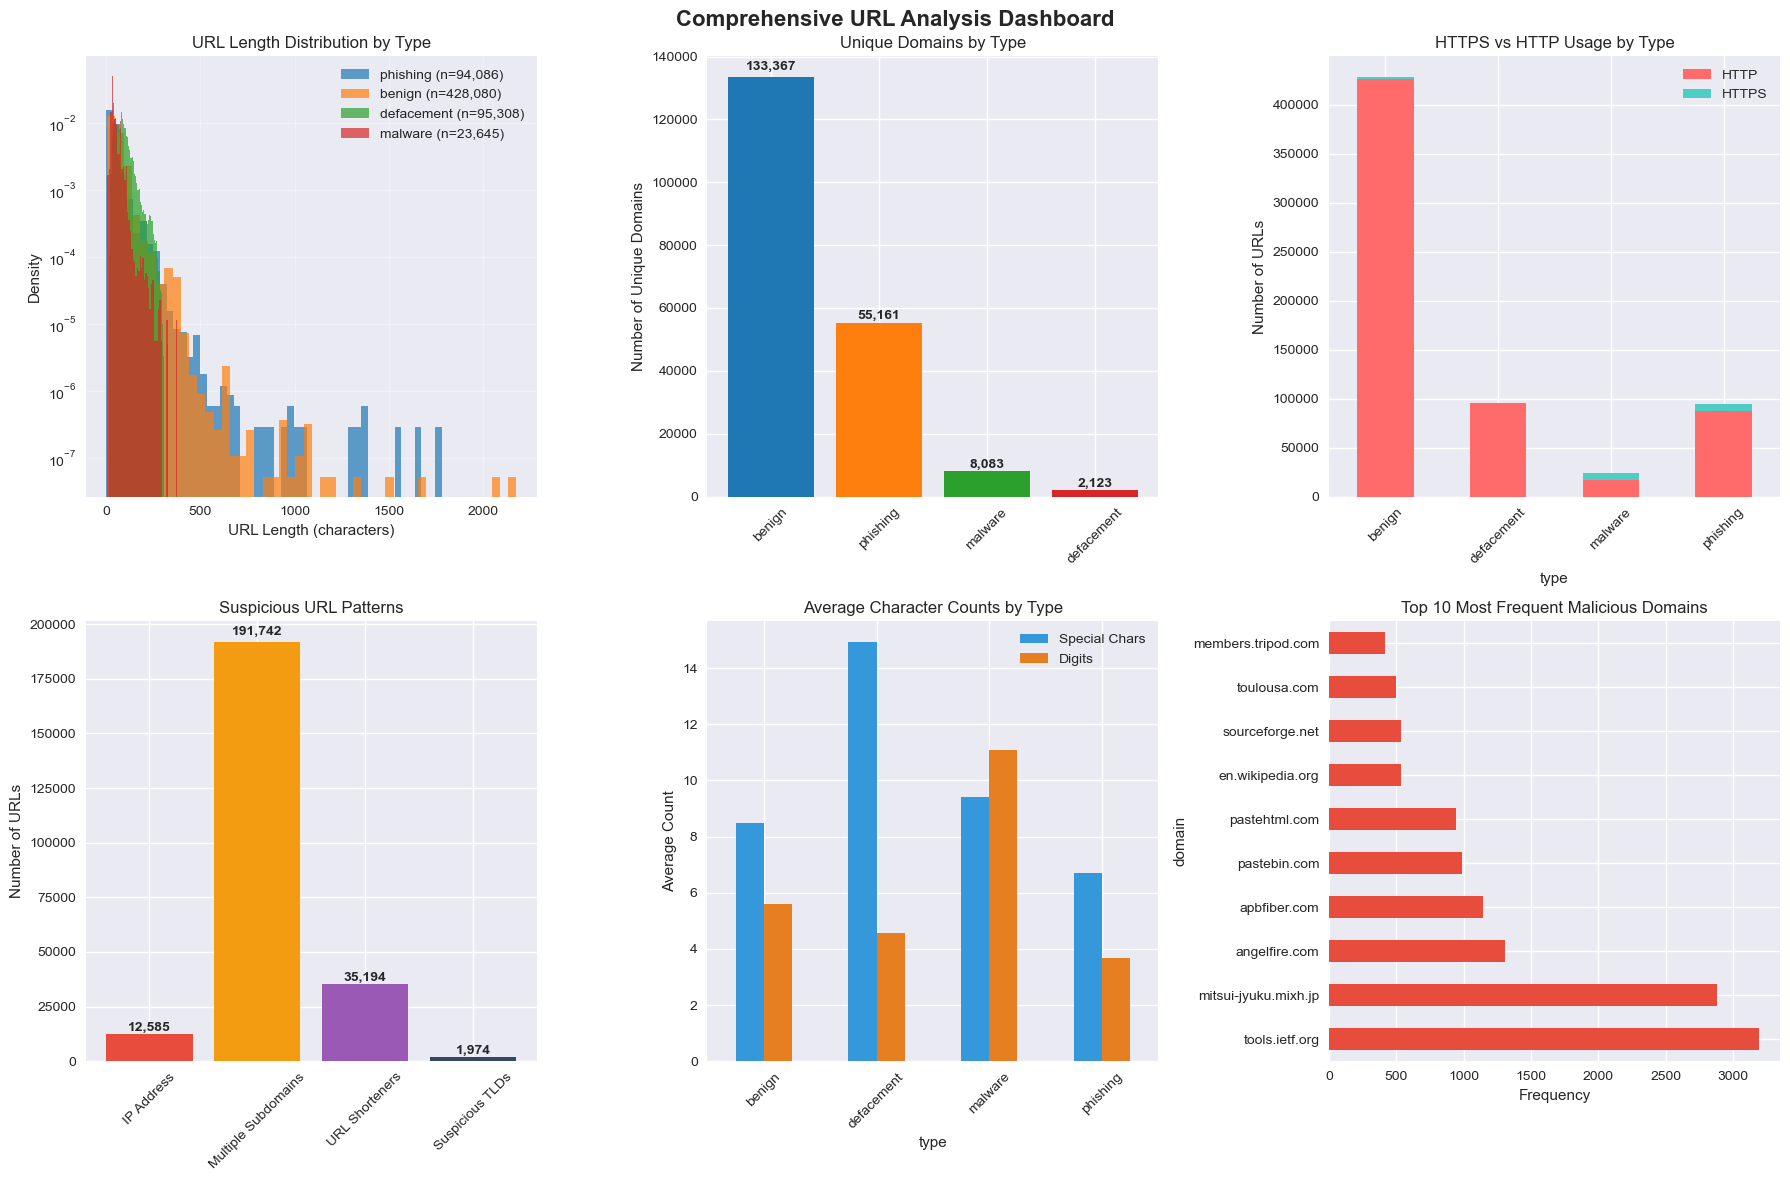

In [26]:
df_enhanced = enhanced_url_analysis(df)

# statistical analysis

In [27]:
def comprehensive_statistical_analysis(df):

    # url length analysis   
    benign_lengths = df[df['type'] == 'benign']['url_length']
    malicious_lengths = df[df['type'] != 'benign']['url_length']
    
    # T-test for length differences
    t_stat, p_value = stats.ttest_ind(benign_lengths, malicious_lengths)
    
    # Cohen's d (effect size)
    pooled_std = np.sqrt(((len(malicious_lengths)-1)*malicious_lengths.var() + 
                         (len(benign_lengths)-1)*benign_lengths.var()) / 
                        (len(malicious_lengths)+len(benign_lengths)-2))
    cohens_d = (malicious_lengths.mean() - benign_lengths.mean()) / pooled_std
    
    print(f"Average benign URL length: {benign_lengths.mean():.2f}")
    print(f"Average malicious URL length: {malicious_lengths.mean():.2f}")
    print(f"Difference: {malicious_lengths.mean() - benign_lengths.mean():.2f} characters ({((malicious_lengths.mean() - benign_lengths.mean())/benign_lengths.mean()*100):.1f}% longer)")
    print(f"T-test p-value: {p_value:.2e}")
    print(f"Effect size (Cohen's d): {cohens_d:.3f}")
    
    # more statistics
    print(f"\nDistribution Analysis:")
    print(f"Median benign URL length: {benign_lengths.median():.2f}")
    print(f"Median malicious URL length: {malicious_lengths.median():.2f}")
    print(f"95th percentile benign: {benign_lengths.quantile(0.95):.2f}")
    print(f"95th percentile malicious: {malicious_lengths.quantile(0.95):.2f}")
    
    # character composition analysis
    print("\n2. CHARACTER COMPOSITION ANALYSIS")
    
    for url_type in df['type'].unique():
        if pd.notna(url_type):
            subset = df[df['type'] == url_type]
            print(f"\n{url_type.upper()}:")
            print(f"  Avg special chars: {subset['special_char_count'].mean():.2f}")
            print(f"  Avg digits: {subset['digit_count'].mean():.2f}")
            print(f"  Special char ratio: {(subset['special_char_count'] / subset['url_length']).mean():.3f}")
    
    # Domain reuse analysis
    print("\n3. DOMAIN REUSE ANALYSIS")
    
    for url_type in df['type'].unique():
        if pd.notna(url_type):
            subset = df[df['type'] == url_type]
            total_urls = len(subset)
            unique_domains = subset['domain'].nunique()
            reuse_rate = 1 - (unique_domains / total_urls)
            
            print(f"{url_type.upper()}:")
            print(f"  Total URLs: {total_urls:,}")
            print(f"  Unique domains: {unique_domains:,}")
            print(f"  Domain reuse rate: {reuse_rate:.1%}")
    
    # a tnova est for differences between all groups
    print("\n4. ANOVA TEST (URL LENGTH ACROSS ALL TYPES)")
    
    groups = [df[df['type'] == t]['url_length'].values for t in df['type'].unique() if pd.notna(t)]
    f_stat, anova_p = stats.f_oneway(*groups)
    print(f"F-statistic: {f_stat:.4f}")
    print(f"p-value: {anova_p:.2e}")
    
    if anova_p < 0.05:
        print("Result: Significant differences exist between URL types")
    else:
        print("Result: No significant differences between URL types")

In [28]:
comprehensive_statistical_analysis(df_enhanced)


Average benign URL length: 57.68
Average malicious URL length: 63.96
Difference: 6.28 characters (10.9% longer)
T-test p-value: 0.00e+00
Effect size (Cohen's d): 0.140

Distribution Analysis:
Median benign URL length: 46.00
Median malicious URL length: 50.00
95th percentile benign: 125.00
95th percentile malicious: 147.00

2. CHARACTER COMPOSITION ANALYSIS

PHISHING:
  Avg special chars: 6.72
  Avg digits: 3.68
  Special char ratio: 0.146

BENIGN:
  Avg special chars: 8.50
  Avg digits: 5.61
  Special char ratio: 0.143

DEFACEMENT:
  Avg special chars: 14.93
  Avg digits: 4.57
  Special char ratio: 0.180

MALWARE:
  Avg special chars: 9.40
  Avg digits: 11.07
  Special char ratio: 0.213

3. DOMAIN REUSE ANALYSIS
PHISHING:
  Total URLs: 94,086
  Unique domains: 55,161
  Domain reuse rate: 41.4%
BENIGN:
  Total URLs: 428,080
  Unique domains: 133,367
  Domain reuse rate: 68.8%
DEFACEMENT:
  Total URLs: 95,308
  Unique domains: 2,123
  Domain reuse rate: 97.8%
MALWARE:
  Total URLs: 23,64

# word clouds
Accessible and readable for people just reading front page on github / README.

In [29]:
def create_enhanced_wordclouds(df):
    """Create word clouds for different URL types, better preprocessing"""
    
    def preprocess_urls(urls):
        """Clean URLs for word cloud generation"""
        # combine urls
        text = ' '.join(urls)
        
        # remove protocols and www 
        text = re.sub(r'https?://', '', text)
        text = re.sub(r'www\.', '', text)
        
        # replace special characters with spaces
        text = re.sub(r'[^\w\s]', ' ', text)
        
        # 'common' url words
        common_words = ['com', 'org', 'net', 'html', 'php', 'asp', 'aspx', 'jsp', 
                       'http', 'https', 'www', 'index', 'default']
        for word in common_words:
            text = re.sub(r'\b' + word + r'\b', '', text, flags=re.IGNORECASE)
        
        return text

    # Plotting code below provided by chatgpt
    
    fig, axes = plt.subplots(2, 2, figsize=(16, 12))
    fig.suptitle('URL Word Clouds by Type', fontsize=16, fontweight='bold')
    
    colors = ['Blues', 'Oranges', 'Greens', 'Reds']
    
    for i, url_type in enumerate(['benign', 'phishing', 'malware', 'defacement']):
        row, col = divmod(i, 2)
        
        if url_type in df['type'].values:
            urls = df[df['type'] == url_type]['url'].tolist()
            text = preprocess_urls(urls)
            
            if text.strip():
                wordcloud = WordCloud(
                    width=600, height=400,
                    background_color='white',
                    colormap=colors[i],
                    max_words=100,
                    relative_scaling=0.5,
                    min_font_size=8
                ).generate(text)
                
                axes[row, col].imshow(wordcloud, interpolation='bilinear')
                axes[row, col].set_title(f'{url_type.title()} URLs (n={len(urls):,})', 
                                       fontweight='bold')
                axes[row, col].axis('off')
            else:
                axes[row, col].text(0.5, 0.5, f'No valid text\nfor {url_type}', 
                                  ha='center', va='center', transform=axes[row, col].transAxes)
                axes[row, col].axis('off')
    
    plt.tight_layout()
    plt.show()

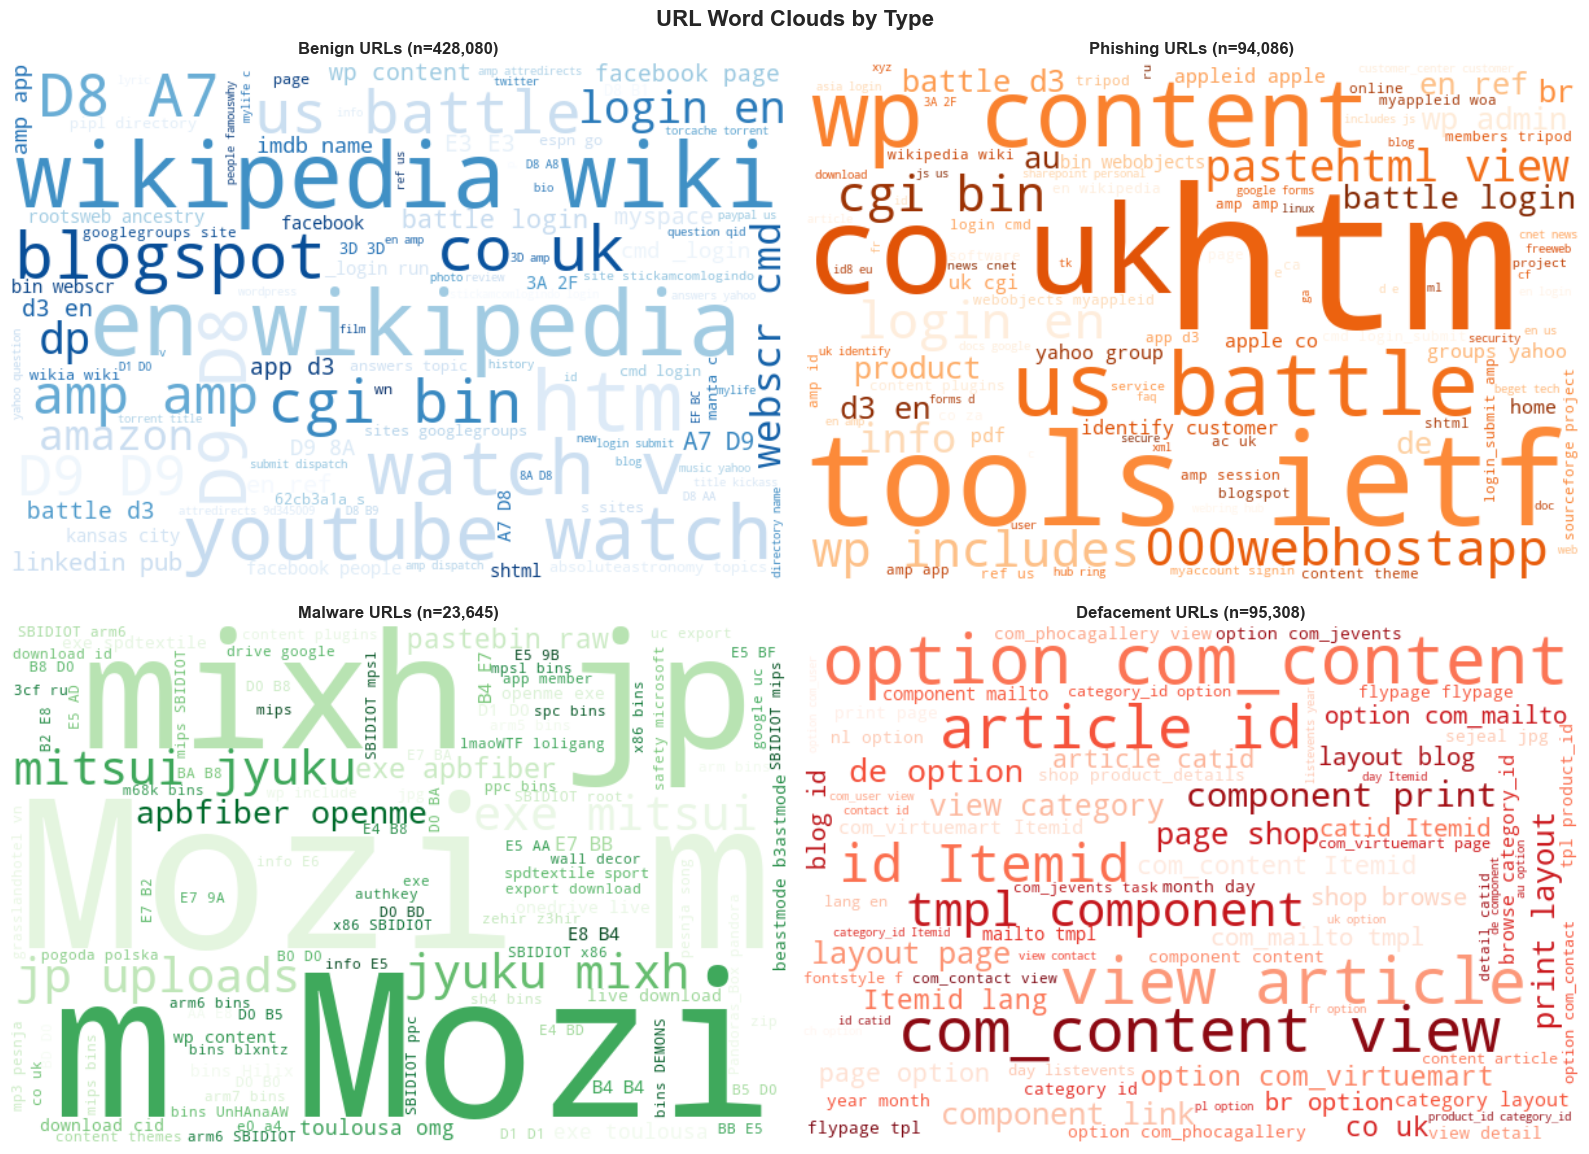

In [38]:
create_enhanced_wordclouds(df_enhanced)

# pattern analysis

In [31]:
def advanced_pattern_analysis(df):

    
    def extract_tld(url):
        try:
            # extract tld from url simply
            domain_part = re.search(r'([^/]+)', url.replace('http://', '').replace('https://', ''))
            if domain_part:
                parts = domain_part.group(1).split('.')
                if len(parts) >= 2:
                    return parts[-1].lower()
        except:
            pass
        return 'unknown'
    
    df['tld'] = df['url'].apply(extract_tld)
    
    print("Top TLDs by type:")
    for url_type in df['type'].unique():
        if pd.notna(url_type):
            tlds = df[df['type'] == url_type]['tld'].value_counts().head(5)
            print(f"\n{url_type.upper()}:")
            for tld, count in tlds.items():
                percentage = (count / len(df[df['type'] == url_type])) * 100
                print(f"  .{tld}: {count:,} ({percentage:.1f}%)")
    
    # path depth analysis
    def get_path_depth(url):
        try:
            # removing protocol and domain
            path_part = re.sub(r'https?://[^/]+', '', url)
            if path_part and path_part != url:
                return len([p for p in path_part.split('/') if p])
            return 0
        except:
            return 0
    
    df['path_depth'] = df['url'].apply(get_path_depth)
    
    print("Average path depth by type:")
    for url_type in df['type'].unique():
        if pd.notna(url_type):
            avg_depth = df[df['type'] == url_type]['path_depth'].mean()
            print(f"  {url_type}: {avg_depth:.2f}")
    
    def count_subdomains(url):
    # no. of subdomains
        try:
            clean_url = re.sub(r'https?://', '', url)
            domain_part = clean_url.split('/')[0]
            
            dots = domain_part.count('.')
            return max(0, dots - 1)  # -1 because .com/.org etc. don't count as subdomain
        except:
            return 0
    
    df['subdomain_count'] = df['url'].apply(count_subdomains)
    
    print("Average subdomain count by type:")
    for url_type in df['type'].unique():
        if pd.notna(url_type):
            avg_subdomains = df[df['type'] == url_type]['subdomain_count'].mean()
            print(f"  {url_type}: {avg_subdomains:.2f}")
    
    # summary visualised
    fig, axes = plt.subplots(1, 3, figsize=(18, 6))
    
    # TLD distribution
    top_tlds = df['tld'].value_counts().head(10)
    top_tlds.plot(kind='bar', ax=axes[0], color='skyblue')
    axes[0].set_title('Top 10 TLDs in Dataset')
    axes[0].set_xlabel('Top-Level Domain')
    axes[0].set_ylabel('Count')
    axes[0].tick_params(axis='x', rotation=45)
    
    # Path depth by type
    df.boxplot(column='path_depth', by='type', ax=axes[1])
    axes[1].set_title('Path Depth Distribution by Type')
    axes[1].set_xlabel('URL Type')
    axes[1].set_ylabel('Path Depth')
    
    # Subdomain count by type
    df.boxplot(column='subdomain_count', by='type', ax=axes[2])
    axes[2].set_title('Subdomain Count Distribution by Type')
    axes[2].set_xlabel('URL Type')
    axes[2].set_ylabel('Subdomain Count')
    
    plt.tight_layout()
    plt.show()
    
    return df

Top TLDs by type:

PHISHING:
  .com: 49,373 (52.5%)
  .org: 9,436 (10.0%)
  .net: 5,450 (5.8%)
  .edu: 3,123 (3.3%)
  .uk: 2,918 (3.1%)

BENIGN:
  .com: 309,261 (72.2%)
  .org: 37,526 (8.8%)
  .net: 18,979 (4.4%)
  .ca: 9,691 (2.3%)
  .edu: 6,927 (1.6%)

DEFACEMENT:
  .com: 29,152 (30.6%)
  .de: 10,768 (11.3%)
  .nl: 5,998 (6.3%)
  .br: 5,004 (5.3%)
  .it: 4,066 (4.3%)

MALWARE:
  .com: 6,008 (25.4%)
  .jp: 2,912 (12.3%)
  .info: 421 (1.8%)
  .ru: 249 (1.1%)
  .org: 225 (1.0%)
Average path depth by type:
  phishing: 0.81
  benign: 0.28
  defacement: 1.83
  malware: 1.69
Average subdomain count by type:
  phishing: 0.99
  benign: 0.42
  defacement: 0.87
  malware: 1.28


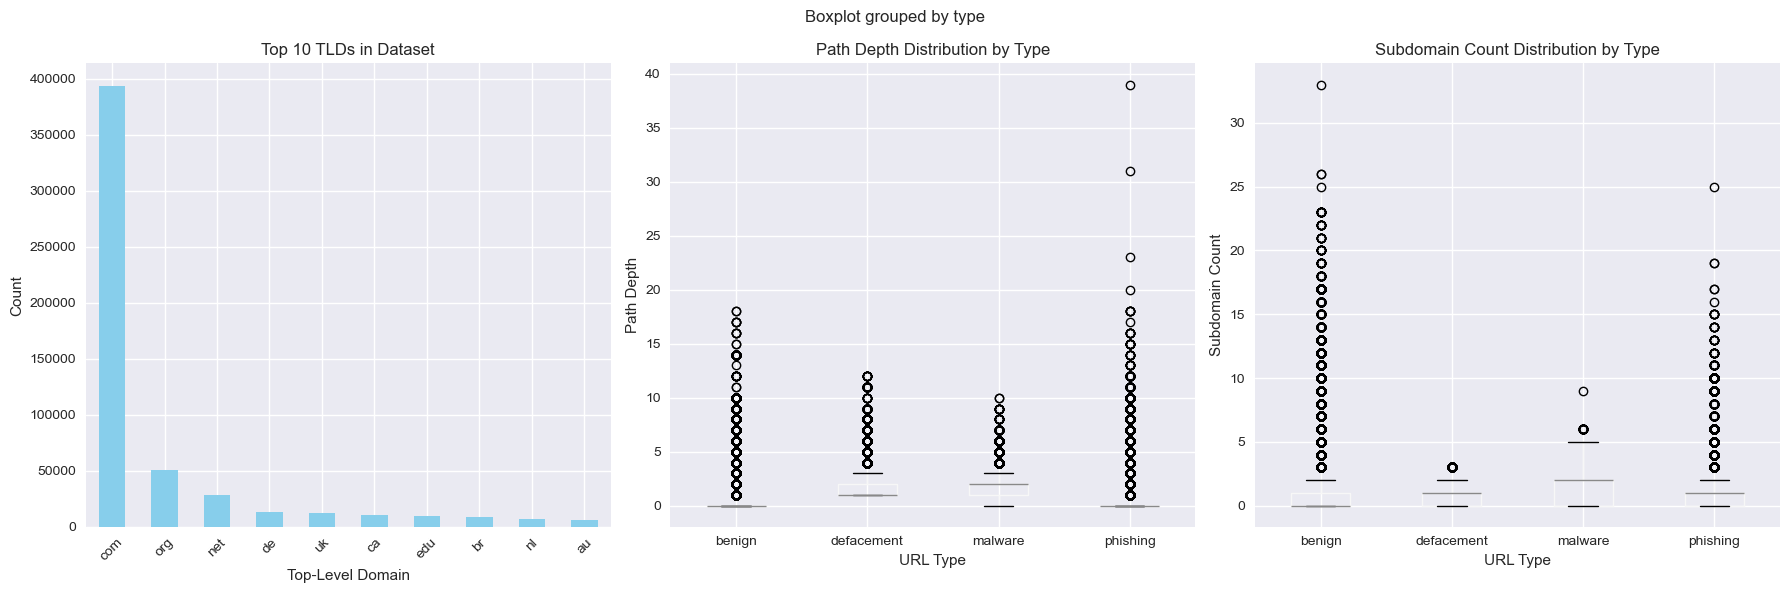

In [32]:
df_final = advanced_pattern_analysis(df_enhanced)

In [33]:
df_final.to_parquet(DATA_PROC / 'enhanced_urls.parquet', index=False)

In [35]:
df_final.shape

(641119, 11)

In [37]:
# new features
df_final.columns

Index(['url', 'type', 'label', 'url_length', 'domain', 'has_https',
       'special_char_count', 'digit_count', 'tld', 'path_depth',
       'subdomain_count'],
      dtype='object')